### Advanced python for Data Science
# Numba: Tell those C++ bullies to get lost
[Based on Scipy 2017 lecture](https://github.com/gforsyth/numba_tutorial_scipy2017/tree/4d74aba75ca8072c616c46fdc27ce78777f35f84)

## Real life example - pairwise Haversine distance
By making a few geometric assumptions, the Haversine formula provies an exceptionally simple way of calculating distance between two latitude/longitude pairs. 

**Haversine**:

$$a=\sin^2\bigl(\frac{\Delta\phi}{2}\bigl)+\cos(\phi_1)\cdot \cos(\phi_2)\cdot\sin^2\bigl(\frac{\Delta\lambda}{2}\bigl)$$
with:
$$c=2\cdot\arctan2(\sqrt{a},\sqrt{1-a})$$
and
$$d=R\cdot c$$
Where: $\phi=\text{latitude  }, \lambda=\text{longitude  }, R=6371 \text{  Earth's mean radius in km}$

In [13]:
import numpy
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [148]:
from numpy import sin,cos,arctan2,sqrt, deg2rad

def haversine_2_points(p1,p2):
    # the actual haversine
    lon1, lat1, lon2, lat2 = deg2rad([p1[0], p1[1], p2[0],p2[1]])
    lon1 = deg2rad(p1[0])
    lat1 = deg2rad(p1[1])
    lon2 = deg2rad(p2[0])
    lat2 = deg2rad(p2[1])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    return 2 * arctan2(sqrt(a), sqrt(1-a))
    
def haversine_pairwise_distance_forloop(X):
    z = numpy.zeros((X.shape[0], X.shape[0]))
    # iterating over all point pairs
    for ii in numpy.arange(X.shape[0]):
        for jj in numpy.arange(X.shape[0]):
            c = haversine_2_points(X[ii,:],X[jj,:])
            z[ii,jj] = 6371 * c
    return z

### Step 0 - Lets generate some data

data be like...

[[37.84690822 28.24782929]
 [34.12855761 30.77240921]
 [38.12719855 28.07479605]
 [32.49078546 27.92387897]
 [31.06281199 32.17091572]]
	...


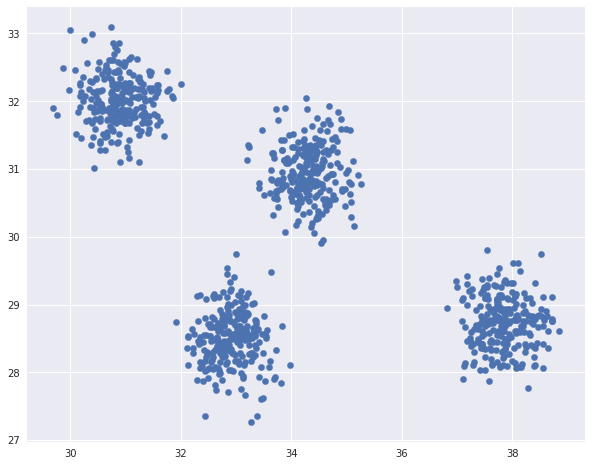

In [178]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=1000, centers=4,
                       cluster_std=0.40, random_state=0)
X = 30 + X[:, ::-1] # flip axes for better plotting
print(f"data be like...\n\n{X[:5,:5]}\n\t...")
plt.figure(figsize=(10,8))
plt.scatter(X[:, 0], X[:, 1], s=40, cmap='viridis')
plt.show()

### Step 1 - Profile
IPython has an `%lprun` magic to profile specific functions within an executed statement. Usage:
`%lprun -f func_to_profile <statement>` (get more help by running `%lprun?` in IPython).

In [149]:
plain = %timeit -o haversine_pairwise_distance_forloop(X[:100,:])

159 ms ± 1.35 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [150]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


The code bellow looks like
```python
%lprun -T timings.txt 
-f haversine_pairwise_distance_forloop 
-f haversine_2_points haversine_pairwise_distance_forloop(X[:500,:500])
```

In [152]:
%lprun -T timings.txt -f haversine_pairwise_distance_forloop -f haversine_2_points haversine_pairwise_distance_forloop(X[:500,:500])


*** Profile printout saved to text file 'timings.txt'. 


In [ ]:
# %load timings.txt
Timer unit: 1e-06 s

Total time: 4.69043 s
File: <ipython-input-148-45f39749a2a1>
Function: haversine_2_points at line 3

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
     3                                           def haversine_2_points(p1,p2):
     4    250000     888981.0      3.6     19.0      lon1, lat1, lon2, lat2 = deg2rad([p1[0], p1[1], p2[0],p2[1]])
     5    250000     383224.0      1.5      8.2      lon1 = deg2rad(p1[0])
     6    250000     330096.0      1.3      7.0      lat1 = deg2rad(p1[1])
     7    250000     321087.0      1.3      6.8      lon2 = deg2rad(p2[0])
     8    250000     323806.0      1.3      6.9      lat2 = deg2rad(p2[1])
     9    250000      93954.0      0.4      2.0      dlon = lon2 - lon1
    10    250000      85127.0      0.3      1.8      dlat = lat2 - lat1
    11    250000    1277441.0      5.1     27.2      a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    12    250000     986715.0      3.9     21.0      return 2 * arctan2(sqrt(a), sqrt(1-a))

Total time: 5.97365 s
File: <ipython-input-148-45f39749a2a1>
Function: haversine_pairwise_distance_forloop at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
==============================================================
    14                                           def haversine_pairwise_distance_forloop(X):
    15         1        399.0    399.0      0.0      z = numpy.zeros((X.shape[0], X.shape[0]))
    16       501        225.0      0.4      0.0      for ii in numpy.arange(X.shape[0]):
    17    250500      89902.0      0.4      1.5          for jj in numpy.arange(X.shape[0]):
    18    250000    5701266.0     22.8     95.4              c = haversine_2_points(X[ii,:],X[jj,:])
    19    250000     181856.0      0.7      3.0              z[ii,jj] = 6371 * c
    20         1          1.0      1.0      0.0      return z

### Step 2 - Using `jit`

We know how to find hotspots now, how do we improve their performance?

We `jit` them!

In [106]:
from numba import jit

In [107]:
@jit
def haversine_pairwise_distance(X):
    z = numpy.zeros((X.shape[0], X.shape[0]))
    for ii in numpy.arange(X.shape[0]):
        for jj in numpy.arange(X.shape[0]):
            lon1 = deg2rad(X[ii,0])
            lat1 = deg2rad(X[ii,1])
            lon2 = deg2rad(X[jj,0])
            lat2 = deg2rad(X[jj,1])
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
            c = 2 * arctan2(sqrt(a), sqrt(1-a))
            z[ii,jj] = 6371 * c
    return z

in the previous code version we got the following results

```164 ms ± 2.44 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)```

In [108]:
jitted = %timeit -o haversine_pairwise_distance(X[:100,:])

715 µs ± 3.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [109]:
plain.best / jitted.best

227.9758935212327

_Conclusion_: jit is **X 228** more **faster** than plain python in this example

### How is this compared to numpy?

In [137]:
from numpy import newaxis

def haversine_pairwise_distance_vectorized(X):
    # Convert to radians
    X_rad = deg2rad(X)
    lng = X_rad[:,0]                     
    lat = X_rad[:,1] 
    dlon = lng[:,newaxis] - lng
    dlat = lat[:,newaxis] - lat
    a = sin(dlat/2)**2 + cos(lat[:,newaxis]) * cos(lat) * sin(dlon/2)**2
    c = 2 * arctan2(sqrt(a), sqrt(1-a))
    return 6371 * c

print(numpy.all(haversine_pairwise_distance_vectorized(X[:100,:]) == haversine_pairwise_distance(X[:100,:])))
haversine_pairwise_distance_vectorized(X[:100,:]) == haversine_pairwise_distance(X[:100,:])

True


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [138]:
numpied = %timeit -o haversine_pairwise_distance_vectorized(X[:100,:])

451 µs ± 3.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [139]:
numpied.best / jitted.best

0.6314367858699811

_Conclusion_: jit is **X 2** more **slower** than numpy vectorization

## Under the Hood -  What is Numba doing to make code run quickly?

In [167]:
# trivial example
@jit
def add(a, b):
    return a + b

add(1, 1)

2

Numba examines Python bytecode and then translates this into an 'intermediate representation'.  To view this IR, run (compile) `add` and you can access the `inspect_types` method.

In [168]:
add.inspect_types()

add (int64, int64)
--------------------------------------------------------------------------------
# File: <ipython-input-167-47c78c928fbf>
# --- LINE 2 --- 
# label 0

@jit

# --- LINE 3 --- 

def add(a, b):

    # --- LINE 4 --- 
    #   a = arg(0, name=a)  :: int64
    #   b = arg(1, name=b)  :: int64
    #   $0.3 = a + b  :: int64
    #   del b
    #   del a
    #   $0.4 = cast(value=$0.3)  :: int64
    #   del $0.3
    #   return $0.4

    return a + b




Ok.  Numba is has correctly inferred the type of the arguments, defining things as `int64` and running smoothly.

What happens if you do `add(1., 1.)` and then `inspect_types`?
> it creates another function with the same name and different input (overloaded functions)


In [170]:
add(1., 1.)
add.inspect_types()

add (int64, int64)
--------------------------------------------------------------------------------
# File: <ipython-input-167-47c78c928fbf>
# --- LINE 2 --- 
# label 0

@jit

# --- LINE 3 --- 

def add(a, b):

    # --- LINE 4 --- 
    #   a = arg(0, name=a)  :: int64
    #   b = arg(1, name=b)  :: int64
    #   $0.3 = a + b  :: int64
    #   del b
    #   del a
    #   $0.4 = cast(value=$0.3)  :: int64
    #   del $0.3
    #   return $0.4

    return a + b


add (float64, float64)
--------------------------------------------------------------------------------
# File: <ipython-input-167-47c78c928fbf>
# --- LINE 2 --- 
# label 0

@jit

# --- LINE 3 --- 

def add(a, b):

    # --- LINE 4 --- 
    #   a = arg(0, name=a)  :: float64
    #   b = arg(1, name=b)  :: float64
    #   $0.3 = a + b  :: float64
    #   del b
    #   del a
    #   $0.4 = cast(value=$0.3)  :: float64
    #   del $0.3
    #   return $0.4

    return a + b




### What about the actual LLVM code?
>The LLVM compiler infrastructure project is a "collection of modular and reusable compiler and toolchain technologies"[3] used to develop compiler front ends and back ends.
LLVM is written in C++ and is designed for compile-time, link-time, run-time, and "idle-time" optimization of programs written in arbitrary programming languages. 

You can see the actual LLVM code generated by Numba using the `inspect_llvm()` method.  Since it's a `dict`, doing the following will be slightly more visually friendly.

In [171]:
for k, v in add.inspect_llvm().items():
    print(k, v)

(int64, int64) ; ModuleID = 'add'
source_filename = "<string>"
target datalayout = "e-m:e-i64:64-f80:128-n8:16:32:64-S128"
target triple = "x86_64-unknown-linux-gnu"

@"_ZN08NumbaEnv8__main__8add$2414Exx" = common local_unnamed_addr global i8* null
@.const.add = internal constant [4 x i8] c"add\00"
@PyExc_RuntimeError = external global i8
@".const.missing Environment" = internal constant [20 x i8] c"missing Environment\00"
@"_ZN08NumbaEnv5numba7targets8arrayobj14numpy_arange_412$3clocals$3e11arange$2412Exxx16dtype$28int64$29" = common local_unnamed_addr global i8* null
@"_ZN08NumbaEnv5numba7targets8arrayobj14numpy_arange_112$3clocals$3e11arange$2411Ex" = common local_unnamed_addr global i8* null

; Function Attrs: norecurse nounwind
define i32 @"_ZN8__main__8add$2414Exx"(i64* noalias nocapture %retptr, { i8*, i32 }** noalias nocapture readnone %excinfo, i64 %arg.a, i64 %arg.b) local_unnamed_addr #0 {
entry:
  %.14 = add nsw i64 %arg.b, %arg.a
  store i64 %.14, i64* %retptr, align 8
  r

WOOOOAAAHHHH!!!

### How about strings instead of number?

In [174]:
@jit
def add_strings_jit(a, b):
    return a + b

add_strings_jit('a', 'b')

'ab'

In [175]:
add_strings_jit.inspect_types()

add_strings_jit (str, str)
--------------------------------------------------------------------------------
# File: <ipython-input-174-53ab24fbb2e8>
# --- LINE 1 --- 
# label 0

@jit

# --- LINE 2 --- 

def add_strings_jit(a, b):

    # --- LINE 3 --- 
    #   a = arg(0, name=a)  :: pyobject
    #   b = arg(1, name=b)  :: pyobject
    #   $0.3 = a + b  :: pyobject
    #   del b
    #   del a
    #   $0.4 = cast(value=$0.3)  :: pyobject
    #   del $0.3
    #   return $0.4

    return a + b




### What's all this pyobject business?  

This means it has been compiled in `object` mode.  This can be a faster than regular python, but not that fast.  
We want those `pyobjects` to be `int64` or another type that can be inferred by Numba. 

Your best bet is forcing `nopython` mode or `@njit` decorator: this will throw an error if Numba finds itself in object mode, so that you _know_ that it can't give you speed.

In [194]:
%%file nopython_failure.py
from numba import jit

@jit
def add_strings_jit(a, b):
    for i in range(100):
        c = i
        f = i + 7
        
    return a + b

add_strings_jit('a', 'b')

Overwriting nopython_failure.py


In [195]:
!numba --annotate-html fail.html nopython_failure.py

[fail.html](fail.html)

### Force `nopython` if code is not optimized

In [196]:
from numba import njit  

@njit
def add_strings_njit(a, b):
    for i in range(100):
        c = i
        f = i + 7
        
    return a + b

add_strings_njit('a', 'b')

TypingError: Failed at nopython (nopython frontend)
[1m[1mInvalid usage of + with parameters (str, str)
Known signatures:
 * (int64, int64) -> int64
 * (int64, uint64) -> int64
 * (uint64, int64) -> int64
 * (uint64, uint64) -> uint64
 * (float32, float32) -> float32
 * (float64, float64) -> float64
 * (complex64, complex64) -> complex64
 * (complex128, complex128) -> complex128
 * (uint8,) -> uint64
 * (uint16,) -> uint64
 * (uint32,) -> uint64
 * (uint64,) -> uint64
 * (int64,) -> int64
 * (int32,) -> int64
 * (int16,) -> int64
 * (int8,) -> int64
 * (float32,) -> float32
 * (float64,) -> float64
 * (complex64,) -> complex64
 * (complex128,) -> complex128
 * parameterized[0m
[0m[1m[1] During: typing of intrinsic-call at <ipython-input-196-cc162d4798d5> (9)[0m
[1m
File "<ipython-input-196-cc162d4798d5>", line 9:[0m
[1mdef add_strings_njit(a, b):
    <source elided>
        
[1m    return a + b
[0m    [1m^[0m[0m

This is not usually a problem with Numba itself but instead often caused by
the use of unsupported features or an issue in resolving types.

To see Python/NumPy features supported by the latest release of Numba visit:
http://numba.pydata.org/numba-doc/dev/reference/pysupported.html
and
http://numba.pydata.org/numba-doc/dev/reference/numpysupported.html

For more information about typing errors and how to debug them visit:
http://numba.pydata.org/numba-doc/latest/user/troubleshoot.html#my-code-doesn-t-compile

If you think your code should work with Numba, please report the error message
and traceback, along with a minimal reproducer at:
https://github.com/numba/numba/issues/new


## I didn't cover...
+ How to use numba with class like structures
+ Vectorization in `numba` possible?
+ example with strings insead of numbers
+ many other stuff...